# Setup

In [32]:
%pip install 'imageio==2.4.0'
%pip install pyvirtualdisplay
%pip install tf-agents
%pip install pyglet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [33]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

# Set up a virtual display for rendering OpenAI gym environments.
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Hyperparameters

In [34]:
env_name = "CartPole-v1" # @param {type:"string"}
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

# Environment

In [35]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Agent

In [36]:
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

Optimizer

In [37]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

# Metrics and Evaluation

In [38]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(eval_env, random_policy, num_eval_episodes)

# Please also see the metrics module for standard implementations of different
# metrics.

18.0

# Data Collection

In [39]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

# Training the Agent

In [40]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 3.1657469272613525
step = 400: loss = 2.270085334777832
step = 600: loss = 2.1022377014160156
step = 800: loss = 1.905388593673706
step = 1000: loss = 1.788546085357666
step = 1000: Average Return = 39.90
step = 1200: loss = 1.74657142162323
step = 1400: loss = 1.4111583232879639
step = 1600: loss = 1.5952855348587036
step = 1800: loss = 1.4455124139785767
step = 2000: loss = 1.2265400886535645
step = 2000: Average Return = 70.90
step = 2200: loss = 1.2241193056106567
step = 2400: loss = 0.952570378780365
step = 2600: loss = 1.0892062187194824
step = 2800: loss = 1.1919059753417969
step = 3000: loss = 1.018675684928894
step = 3000: Average Return = 240.10
step = 3200: loss = 1.011176347732544
step = 3400: loss = 0.8436222076416016
step = 3600: loss = 0.8598305583000183
step = 3800: loss = 0.8754538297653198
step = 4000: loss = 0.8421288728713989
step = 4000: Average Return = 243.30
step = 4200: loss = 0.9024510383605957
step = 4400: loss = 0.5957927703857422
step = 4

# Visualization

(-9.059999895095824, 550.0)

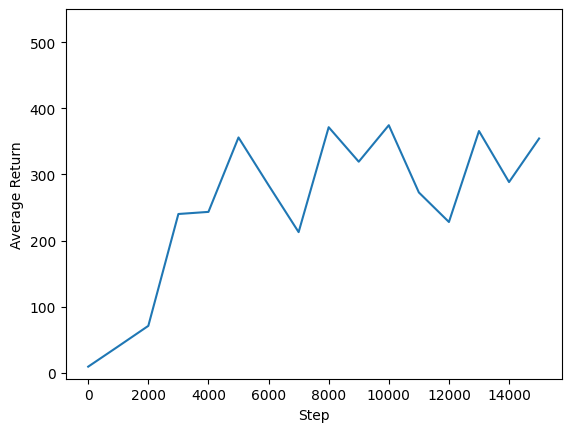

In [43]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=550)

In [42]:
returns

[9.2,
 39.9,
 70.9,
 240.1,
 243.3,
 355.9,
 283.7,
 212.7,
 371.4,
 319.2,
 374.4,
 272.7,
 228.0,
 365.6,
 288.4,
 354.3]